In [60]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

import collections
import hashlib
import numbers
from sys import getsizeof
from datetime import datetime
from pathlib import Path
import os
import re

# tensorflow and its dependencies
import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim

## user defined modules
## user defined modules
# kernel rnn cell
import spiking_cell_bare as spiking_cell
import adding_problem

In [61]:
# Training Parameters
# Training Parameters
weight_learning_rate = 1e-5
training_steps = 100
batch_size = 25
training_size=batch_size*training_steps
epochs=5
test_size=1000
display_step = 10
grad_clip=100
# Network Parameters
num_input = 1 # adding problem data input (first input are the random digits , second input is the mask)
num_context=1
time_steps = 50
num_units_input_layer=50
num_hidden = 100 # hidden layer num of features
num_output = 1 # value of the addition estimation
#
# save dir
log_dir = os.environ['HOME']+"/MyData/KeRNL/logs/bptt_snn_addition_dataset/bp_snn_add_T_%1.0e_eta_W_%1.0e_batch_%1.0e_hum_hidd_%1.0e_gc_%1.0e_steps_%1.0e_epoch_%1.0e_run_%s" %(time_steps,weight_learning_rate,batch_size,num_hidden,grad_clip,training_steps,epochs, datetime.now().strftime("%Y%m%d_%H%M"))
log_dir
# create a training and testing dataset
training_x, training_y = adding_problem.get_batch(batch_size=training_size,time_steps=time_steps)
testing_x, testing_y = adding_problem.get_batch(batch_size=test_size,time_steps=time_steps)

Text(0, 0.5, 'output class')

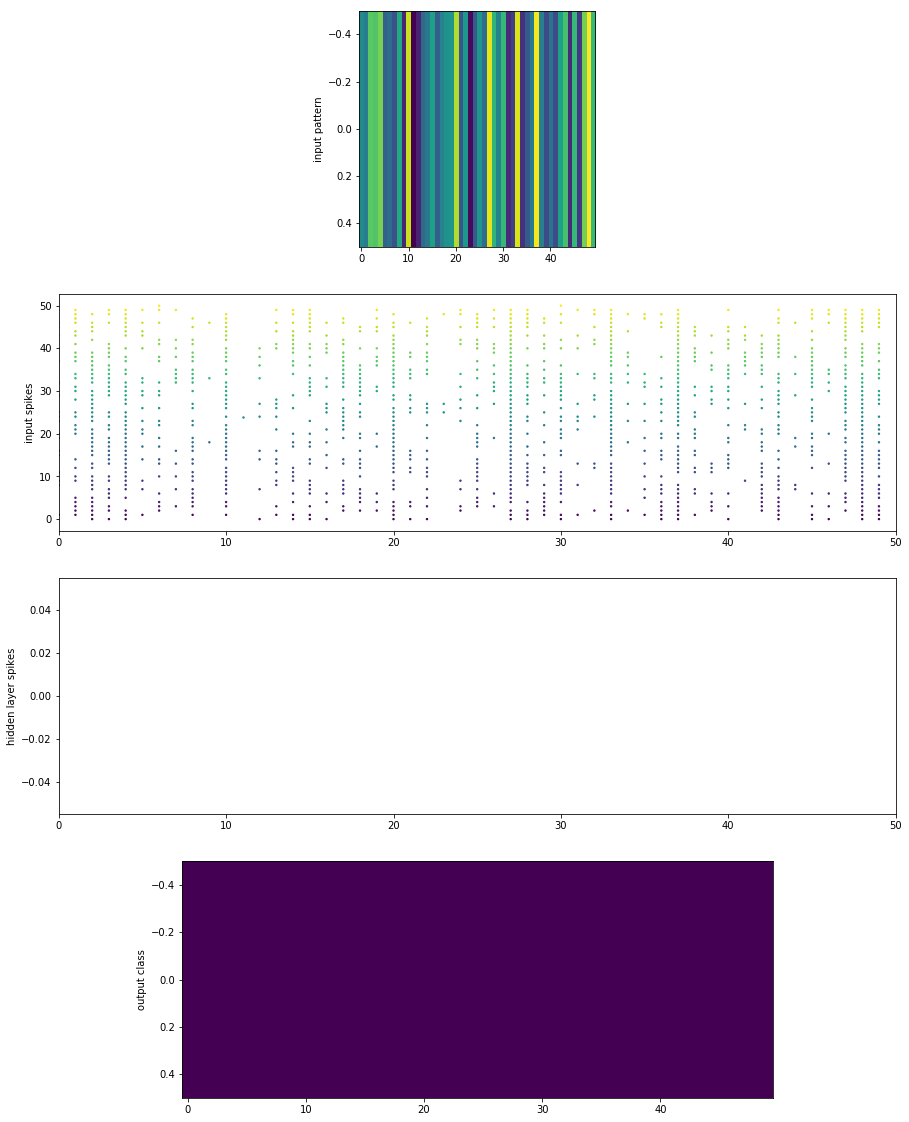

In [63]:
def _hinton_identity_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=1):
    if dtype is None:
        dtype=tf.float32
    #extract second dimension
    W_rec=tf.eye(shape[-1],dtype=dtype)
    new_shape=[shape[0]-shape[-1],shape[-1]]
    W_in=tf.random_normal(new_shape,mean=0,stddev=0.001)
    return tf.concat([W_in,W_rec],axis=0)

## define KeRNL unit
def bptt_snn_all_states(x,context):
    with tf.variable_scope('input_layer') as scope:
        input_layer_cell=spiking_cell.input_spike_cell(num_units=num_units_input_layer)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x)
    with tf.variable_scope('hidden_layer') as scope:
        hidden_layer_cell=spiking_cell.conductance_spike_cell(num_units=num_hidden,output_is_tuple=True,tau_refract=1.0,tau_m=20.0,kernel_initializer=_hinton_identity_initializer)
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=tf.concat([output_l1,context],-1))
    with tf.variable_scope('output_layer') as scope :
        output_layer_cell=spiking_cell.output_spike_cell(num_units=num_output)
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)
    return output_voltage,output_hidden, tf.concat([output_l1,context],-1)


# Training Parameters
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # input to graph
    X=tf.placeholder('float',shape=[batch_size,time_steps,num_input])
    Context=tf.placeholder('float',shape=[batch_size,time_steps,num_context])
    # define out
    output_voltages,hidden_states,input_states=bptt_snn_all_states(X,Context)
    
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    
    init=tf.global_variables_initializer()
    
    
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x=training_x[0:batch_size,:,:]
    batch_x_full=np.expand_dims(batch_x[:,:,0],axis=-1)
    context_input=np.expand_dims(batch_x[:,:,1],axis=-1)
    
    outputs,hiddens,inputs=sess.run([output_voltages,hidden_states,input_states], feed_dict={X: batch_x_full,Context:context_input})
    
voltages=outputs[9,:,:]
hidden_spikes=hiddens.spike[9,:,:]
input_spikes=inputs[9,:,:]
plt.figure(figsize=[15,20])

#ax1=plt.subplot(311)
#colors_map=cm.viridis(np.linspace(0,1,voltages.shape[1]))
#for t in range(num_classes):
#    ax1.plot(voltages[:,t],color=colors_map[t,:])
#    plt.xlim([0,timesteps])

ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x_full[9]))
ax1.set_aspect(50)
plt.ylabel('input pattern')
ax2=plt.subplot(412)
colors_map=cm.viridis(np.linspace(0,1,num_units_input_layer+num_context))
for t in range(time_steps):
    cross=np.argwhere(input_spikes[t,:])
    ax2.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('input spikes')
  
ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(time_steps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.imshow(np.transpose(voltages))
ax1.set_aspect(20)
plt.ylabel('output class')

    


### test spiking and output activity

test initializations 

Text(0, 0.5, 'output class')

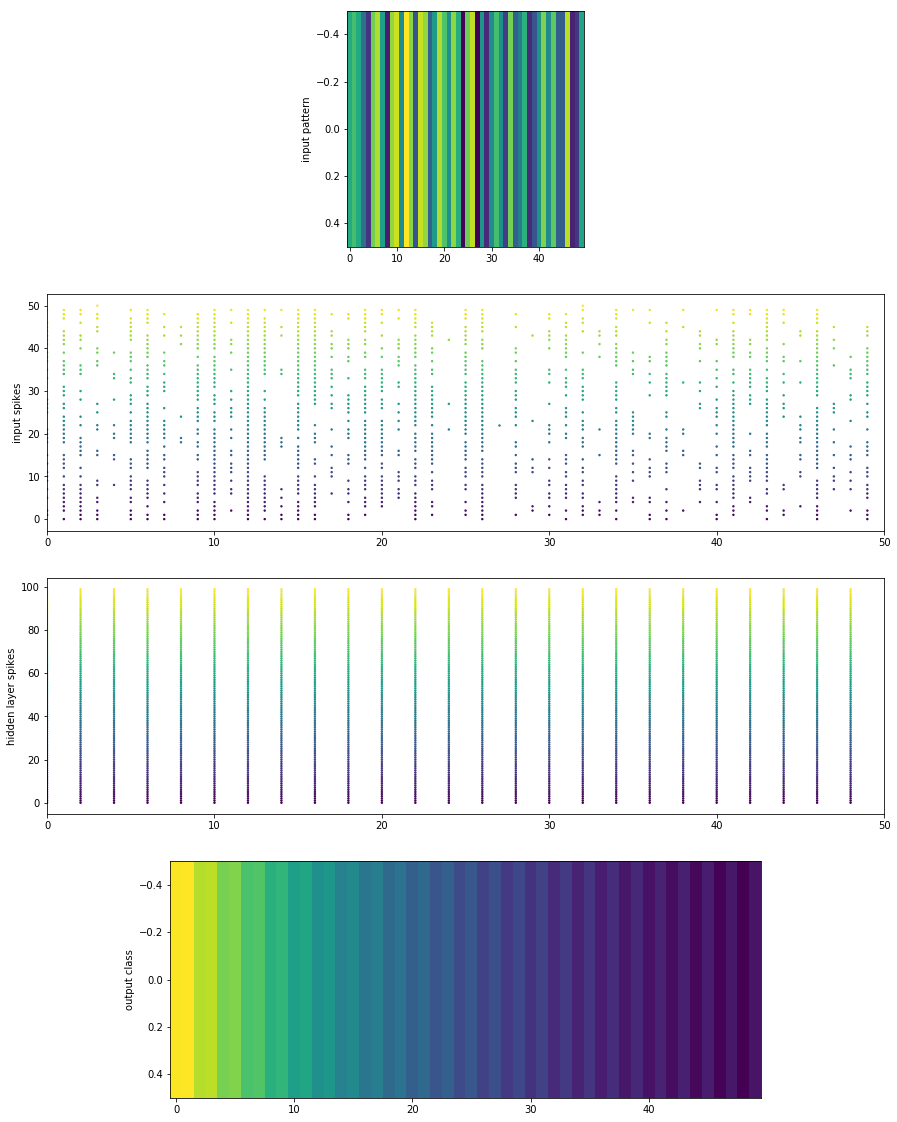

In [58]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x=training_x[0:batch_size,:,:]
    batch_x_full=np.expand_dims(batch_x[:,:,0],axis=-1)
    context_input=np.expand_dims(batch_x[:,:,1],axis=-1)
    
    outputs,hiddens,inputs=sess.run([output_voltages,hidden_states,input_states], feed_dict={X: batch_x_full,Context:context_input})
    
voltages=outputs[9,:,:]
hidden_spikes=hiddens.spike[9,:,:]
input_spikes=inputs[9,:,:]
plt.figure(figsize=[15,20])

#ax1=plt.subplot(311)
#colors_map=cm.viridis(np.linspace(0,1,voltages.shape[1]))
#for t in range(num_classes):
#    ax1.plot(voltages[:,t],color=colors_map[t,:])
#    plt.xlim([0,timesteps])

ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x_full[9]))
ax1.set_aspect(50)
plt.ylabel('input pattern')
ax2=plt.subplot(412)
colors_map=cm.viridis(np.linspace(0,1,num_units_input_layer+num_context))
for t in range(time_steps):
    cross=np.argwhere(input_spikes[t,:])
    ax2.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('input spikes')
  
ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(time_steps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.imshow(np.transpose(voltages))
ax1.set_aspect(20)
plt.ylabel('output class')

    


In [46]:
inputs

array([[[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  0.],
        [ 1.,  0.,  1., ...,  1.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  0.],
        [ 1.,  0.,  1., ...,  1.,  1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0.,  1., ...,  1.,  1.,  0.]],

       [[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  1.,  1., ...,  1.,  1.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 1.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  1.,  0., ...,  1.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  0.

### test gradients 

In [ ]:
def SNN_Full(x):
    with tf.variable_scope('input_layer') as scope: 
        input_layer_cell=spiking_cell_bare.input_spike_cell(num_units=num_unit_input_layer)
        input_initial_state = input_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x,initial_state=input_initial_state)
    with tf.variable_scope('hidden_layer') as scope: 
        hidden_layer_cell=spiking_cell_bare.conductance_spike_Cell(num_units=num_hidden,output_is_tuple=True,tau_refract=5.0)
        hidden_initial_state = hidden_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=output_l1,initial_state=hidden_initial_state)
    with tf.variable_scope('output_layer') as scope : 
        output_layer_cell=spiking_cell_bare.output_spike_cell(num_units=num_classes)
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)

    return output_voltage, output_hidden

In [ ]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # define weights and inputs to the network
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    # define a function for extraction of variable names
    SNN_output,SNN_hidden_states=SNN_Full(X)
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    # 
    find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for keRNL 
    with tf.name_scope('SNN_Trainables') as scope:
        SNN_hidden_kernel_index= find_joing_index(trainables,'hidden_layer','kernel')
        SNN_hidden_bias_index= find_joing_index(trainables,'hidden_layer','bias')
        SNN_output_kernel_index= find_joing_index(trainables,'output_layer','kernel')
        SNN_output_bias_index= find_joing_index(trainables,'output_layer','bias')
    # 
        SSN_weight_training_indices=np.asarray([SNN_hidden_kernel_index,SNN_hidden_bias_index,SNN_output_kernel_index,SNN_output_bias_index],dtype=np.int)
        SNN_weight_trainables= [trainables[k] for k in SSN_weight_training_indices]
    #
    #define loss functions  
    ##################
    # SNN train ####
    ##################
    with tf.name_scope("SNN_train") as scope:
        # outputs 
        SNN_loss_output_prediction=tf.losses.softmax_cross_entropy(onehot_labels=Y,logits=SNN_output[:,-1,:])
        SNN_prediction = tf.nn.softmax(SNN_output[:,-1,:])
        SNN_correct_pred = tf.equal(tf.argmax(SNN_prediction, 1), tf.argmax(Y, 1))
        SNN_accuracy = tf.reduce_mean(tf.cast(SNN_correct_pred, tf.float32))
       # define optimizer 
        SNN_weight_optimizer = tf.train.AdamOptimizer(learning_rate=weight_learning_rate)
        
       
        with tf.name_scope('SNN_train_weights') as scope: 
            SNN_grad_cost_trainables=tf.gradients(SNN_loss_output_prediction,SNN_weight_trainables)
            
            # crop the gradients  
            #SNN_weight_grads_and_vars=list(zip(SNN_grad_cost_trainables,SNN_weight_trainables))
            #SNN_cropped_weight_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else (grad,var) for grad,var in SNN_weight_grads_and_vars]
            # apply gradients 
            #SNN_weight_train_op = SNN_weight_optimizer.apply_gradients(SNN_cropped_weight_grads_and_vars)
        with tf.name_scope('SNN_check_gradients') as scope:
            spike_to_voltage_gradient=tf.gradients(ys=SNN_hidden_states.v_mem,xs=SNN_hidden_states.spike)
        init = tf.global_variables_initializer()
    

In [ ]:
with tf.Session(graph=graph,) as sess : 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        #print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 
spike_to_voltage_gradient

In [ ]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input))
    outputs,hidden_states=sess.run([SNN_output,SNN_hidden_states],feed_dict={X:batch_x, Y:batch_y})
    spike_2_v_mem_grad=sess.run(SNN_grad_cost_trainables,feed_dict={X:batch_x, Y:batch_y})

In [ ]:
v_mems=hidden_states.v_mem
plt.figure(figsize=[15,10])
plt.imshow(np.transpose(v_mems[9,:,:]))
plt.colorbar()

looks like negative values dominates the activity of the cells, question is should I change something about the negative amplitudes

In [ ]:
a=spike_2_v_mem_grad[0]
plt.figure(figsize=[10,15])
plt.imshow(a)
plt.colorbar()


In [14]:
a=np.arange(1,50)
a

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [15]:
a[-1-20:
 ]

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49])